# TITANIC

![titanic.jpeg](titanic.jpeg)

#### Variables

- survival -> 0 = No, 1 = Yes
- pclass -> 1 = 1st, 2 = 2nd, 3 = 3rd
- sibsp -> # of siblings / spouses aboard the Titanic
- parch -> # of parents / children aboard the Titanic
- fare -> Passenger fare

In [1]:
#general 
import pandas as pd
import numpy as np

np.random.seed(42)

# pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
df_train = pd.read_csv(r'C:\Users\migue\Documents\datasets_kaggle\Titanic\train.csv')

In [3]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [6]:
df_train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


### Predicting the target

#### Preprocessing

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    from sklearn.impute import SimpleImputer

except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy = "median")),
    ("std_scaler", StandardScaler())
])

num_pipeline.fit_transform(df_train)

array([[-0.56573646,  0.43279337, -0.47367361, -0.50244517],
       [ 0.66386103,  0.43279337, -0.47367361,  0.78684529],
       [-0.25833709, -0.4745452 , -0.47367361, -0.48885426],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, -0.17626324],
       [-0.25833709, -0.4745452 , -0.47367361, -0.04438104],
       [ 0.20276197, -0.4745452 , -0.47367361, -0.49237783]])

In [9]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index = X.columns)
        return self
    
    def transform(self, X, y = None):
        return X.fillna(self.most_frequent_)

In [10]:
try: 
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder

except ImportError:
    from future_encoders import OneHotEncoder

In [11]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_ecoder", OneHotEncoder(sparse = False)),    
])

cat_pipeline.fit_transform(df_train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [12]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [13]:
X_train = preprocess_pipeline.fit_transform(df_train)
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [14]:
y_train = df_train["Survived"]

### Random Forest

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [16]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 16)
forest_scores.mean()

0.8103896103896104

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators' : randint(low = 10, high = 1000),
                  'max_leaf_nodes' : randint(low = 10, high = 100),
                  }

forest_clf = RandomForestClassifier(random_state = 42)
forest_search = RandomizedSearchCV(forest_clf, param_distributions = param_distribs,
                                  n_iter = 16, cv = 10, random_state = 42)
forest_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_iter=16,
                   param_distributions={'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1B53E808>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1B53EEE0>},
                   random_state=42)

In [18]:
forest_search.best_estimator_

RandomForestClassifier(max_leaf_nodes=69, n_estimators=286, random_state=42)

In [19]:
forest_search.best_params_

{'max_leaf_nodes': 69, 'n_estimators': 286}

In [20]:
forest_best_model = forest_search.best_estimator_
forest_best_model_scores = cross_val_score(forest_best_model, X_train, y_train, cv = 10)
forest_best_model_scores.mean()

0.8384394506866416

### Adaboost

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1),
    n_estimators = 100, algorithm = "SAMME.R",
    learning_rate = 0.5, random_state = 42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100, random_state=42)

In [22]:
ada_scores = cross_val_score(ada_clf, X_train, y_train, cv = 10)
ada_scores.mean()

0.8047565543071162

In [23]:
from scipy.stats import uniform

ada_param = {'n_estimators' : randint(low = 10, high = 700),
             'learning_rate': uniform(0.1, 2.0)}

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1),
    random_state = 42)

ada_search = RandomizedSearchCV(ada_clf, param_distributions = ada_param,
                                n_iter = 16, cv = 10, random_state = 42)
ada_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                random_state=42),
                   n_iter=16,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x106E8490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x106E8640>},
                   random_state=42)

In [24]:
ada_search.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.29994983163600575, n_estimators=468,
                   random_state=42)

In [25]:
ada_search.best_params_

{'learning_rate': 0.29994983163600575, 'n_estimators': 468}

In [26]:
ada_best_model = ada_search.best_estimator_
ada_best_model_scores = cross_val_score(ada_best_model, X_train, y_train, cv = 10)
ada_best_model_scores.mean()

0.8137453183520599

### Feature engineering

In [27]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

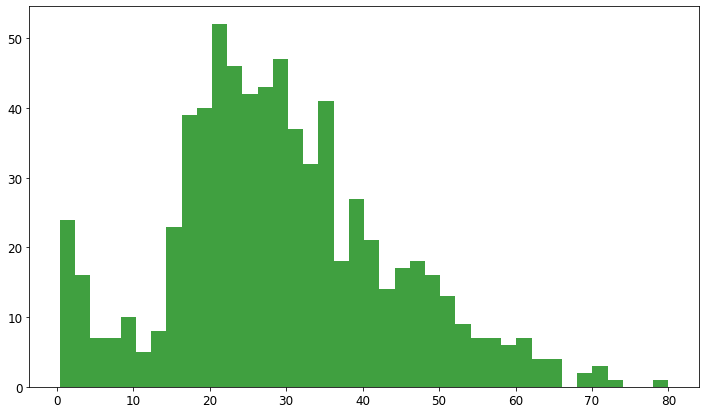

In [28]:
plt.figure(figsize  = (12, 7))
plt.hist(df_train.Age, 40, density = False, facecolor = 'g', alpha = 0.75)
plt.show()

In [29]:
df_train["AgeBucket"] = df_train["Age"] // 15 * 15
df_train[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


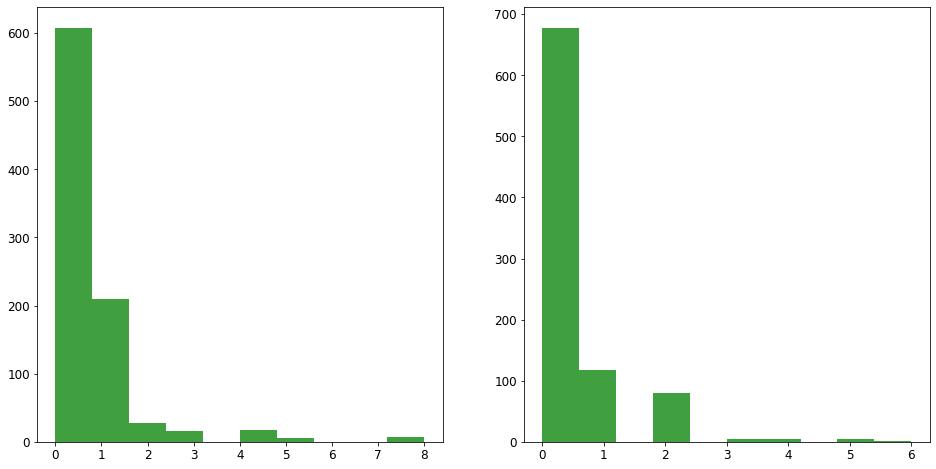

In [30]:
plt.figure(figsize = (16,8))

plt.subplot(121)
plt.hist(df_train.SibSp, 10, density = False, facecolor = 'g', alpha = 0.75)

plt.subplot(122)
plt.hist(df_train.Parch, 10, density = False, facecolor = 'g', alpha = 0.75)

plt.show()

In [31]:
df_train["RelativesOnboard"] = df_train["SibSp"] + df_train["Parch"]
df_train[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [32]:
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "Fare", "AgeBucket", "RelativesOnboard"])),
    ("imputer", SimpleImputer(strategy = "median")),
    ("std_scaler", StandardScaler())
])

num_pipeline.fit_transform(df_train)

array([[-0.56573646, -0.50244517, -0.49336646,  0.05915988],
       [ 0.66386103,  0.78684529,  0.62234298,  0.05915988],
       [-0.25833709, -0.48885426, -0.49336646, -0.56097483],
       ...,
       [-0.1046374 , -0.17626324, -0.49336646,  1.29942929],
       [-0.25833709, -0.04438104, -0.49336646, -0.56097483],
       [ 0.20276197, -0.49237783,  0.62234298, -0.56097483]])

In [33]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_ecoder", OneHotEncoder(sparse = False)),    
])

cat_pipeline.fit_transform(df_train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [34]:
preprocess_pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

X_train = preprocess_pipeline.fit_transform(df_train)
X_train

array([[-0.56573646, -0.50244517, -0.49336646, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.78684529,  0.62234298, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.48885426, -0.49336646, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 , -0.17626324, -0.49336646, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.04438104, -0.49336646, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.49237783,  0.62234298, ...,  0.        ,
         1.        ,  0.        ]])

#### Bagging

In [35]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state = 42),
                            n_estimators = 300,
                            max_samples = 100, bootstrap = True,
                            n_jobs = -1, random_state = 42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=300, n_jobs=-1,
                  random_state=42)

In [36]:
bag_scores = cross_val_score(bag_clf, X_train, y_train, cv = 10)
bag_scores.mean()

0.8328214731585517

In [37]:
bag_distribs = {'n_estimators' : randint(low = 10, high = 1000),
                'max_samples' : randint(low = 10, high = 300),
                  }

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state = 42),
                            bootstrap = True, n_jobs = -1, random_state = 42)

bag_search = RandomizedSearchCV(bag_clf, param_distributions = bag_distribs,
                                  n_iter = 16, cv = 10, random_state = 42)

bag_search.fit(X_train, y_train)
bag_clf_best_model = bag_search.best_estimator_

In [38]:
bag_search.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=159, n_estimators=318, n_jobs=-1,
                  random_state=42)

In [39]:
bag_clf_best_model_scores = cross_val_score(bag_clf_best_model, X_train, 
                                            y_train, cv = 10)
bag_clf_best_model_scores.mean()

0.8395505617977527